# Linear Models

In this notebook, we describe a general linear stochastic model which assumes that the series is generated by a linear combination of white noise. We first build our foundation by considering the theory behind inear stationary (ARMA) and non-stationary models (ARIMA). Then proceed to layout the recipe on choosing the best model given a particular dataset. We end our discussion by demonstrating how to apply the techniques we've learned on the **M5 Food Category Dataset**.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels as sm
from matplotlib import rcParams
import matplotlib.pyplot as plt

# Preamble for prettification
rcParams.update({'figure.figsize': (16, 4), 'axes.spines.top': False,
                 'axes.spines.right': False, 'axes.labelsize': 14,
                 'axes.titlesize': 16, 'axes.titleweight': 'bold'})

## Linear Stationary Models

### Two Equivalent Forms of the General Linear Process

Linear models have two equivalent forms.

$$
\tilde{z}_t = a_t + \psi_1 a_{t-1} + \psi_2 a_{t-2} + ... \tag{1} \label{ma-infty}
$$

where $\tilde{z}_t = z_t - \mu$ is the mean-centered time-series, $a_i$'s are white noise, and $\psi$ are the weights of the model. This form refers to the gineral linear process which represents the mean-centered time series $\tilde{z}_t$ as a weighted sum of present and past values of the "white noise" process $a_t$.

The white noise process is a sequence of uncorrelated random variables with mean zero and constant variance. Recall that the autocovariance $\gamma_k$ and autocorrelation $\rho_k$ of white noise has a simple form:

$$
\gamma_k = \begin{cases} \sigma_a^2 & k = 0 \\ 0 & k \neq 0 \end{cases} \tag{2}
$$

$$
\rho_k = \begin{cases} 1 & k = 0 \\ 0 & k \neq 1 \end{cases} \tag{3}
$$

For $\tilde{z}_t$ to be defined as a stationary process, the coefficients $\psi_j$ must be *absolutely summable*, i.e.:

$$
\sum_{j=0}^{\infty} | \psi_j | < \infty \tag{4} \label{abs-sum}
$$

When Equation [(4)](#mjx-eqn-abs-sum) holds, we can also write $\tilde{z}_t$ as a weighted sum of "regressed" past deviations $\tilde{z}_{t-1}, \tilde{z}_{t-2}, ...$ of the process.

$$
\tilde{z}_t = \pi_1 \tilde{z}_{t-1} + \pi_2 \tilde{z}_{t-2} + ... + a_t \tag{5} \label{ar-infty}
$$

#### Relationship between the $\psi$ and $\pi$

To illustrate the relationship between the weights $\psi$ and $\pi$, we first define the backward shift operator $B$ as:

$$
Bz_t = z_{t-1} \tag{6}
$$

or equivalently,

$$
B^j z_t = z_{t-j} \tag{7}
$$

We also use the forward shift operator $F = B^{-1}$ defined as:

$$
F z_t = z_{t+1} \tag{8}
$$

or equivalently,

$$
F^j z_t = z_{t+j} \tag{9}
$$

Using the backshift operator $B$ we can write the general linear process from Equation [(1)](#mjx-eqn-ma-infty) as:

$$
\tilde{z}_t = \left( 1 + \sum_{j-1}^\infty \psi_j B^j \right) a_t \tag{10}
$$

which we simplify as:

$$
\tilde{z}_t = \psi(B) a_t \tag{11} \label{ma-comp}
$$

where we define $\psi(B)$ as,

$$
\psi(B) = \sum_{j=0}^\infty \psi_j B^j \tag{12} 
$$

with $\psi_0 = 1$. This $\psi(B)$ called the transfer function of the linear filter relating $\tilde{z}_t$ to $a_t$.

Similarly, we can write Equation [(5)](#mjx-eqn-ar-infty), as

$$
\left(1 - \sum_{j=1}^\infty \pi_j B^j \right) \tilde{z}_t = a_t \tag{13}
$$

which we simplify as,

$$
\pi(B)\tilde{z}_t = a_t \tag{14} \label{ar-comp}
$$

wherin we define $\pi(B)$ as,

$$
\pi(B) = 1 - \sum_{j=1}^\infty \pi_j B^j \tag{15}
$$

Now, looking and multiplying Equation [(14)](#mjx-eqn-ar-comp) by $\psi(B)$, we get,

$$
\psi(B)\pi(B)\tilde{z}_t = \psi(B) a_t \tag{16}
$$

But from Equation [(11)](#mjx-eqn-ma-comp), we know that $\psi(B)a_t$ is also equal to $\tilde{z}_t$, which means:

$$
\psi(B)\pi(B)\tilde{z}_t = \tilde{z}_t \tag{17}
$$

Hnence, $\psi(B)\pi(B) = 1$ or,

$$
\pi(B) = \psi^{-1}(B) \tag{18}
$$

Which shows that the two forms we presented are equivalent. In other words, we can derive the weights $\pi$ from $\psi$ and vice versa.

### Invertibility

A time series is invertible if the error representation of the time series can be inverted into a regressive representation of past observations. The invertible requirement simply means that the series can be written in the form of Equation [(14)](#mjx-eqn-ar-comp). As such, the invertible condition is if,

$$
\sum_{j=0}^{\infty} |\pi_j| < \infty \tag{19}
$$

### Autoregressive and Moving Average Process

The current representations that we have for the general linear process would not be useful in practice since we need an infinite number of parameters $\psi_j$ and $\pi_j$. To introduce parsimony on our models, we discuss the Autorgressive Moving Average (ARMA) model and dissect its components. This model is much more useful for practical applications.

#### Autoregressive Process

Consider the special case of Equation [(5)](#mjx-eqn-ar-infty), where we only have the first $p$ of the weights are non-zero:

$$
\tilde{z}_t = \phi_1 \tilde{z}_{t-1} + \phi_2 \tilde{z}_{t-2} + ... + \phi_p \tilde{z}_{p} + a_t \tag{20}
$$

where the weights are now the finite set of parameters $\phi_1, \phi_2, ..., \phi_p$. This is the autoregressive process of order $p$ or $AR(p)$ process.

In particular let's take the case of AR(1):

$$
\tilde{z}_t = \phi_1 \tilde{z}_{t-1} + a_t \tag{21}
$$

##### Example 1: Generating an AR(1) process

Let's take the case where $\phi_1 = 0.50$ and we want to generate `250` data points.

In [2]:
# Set the size variable and random seed
size = 250
np.random.seed(1337)
phi = [1, 0.50]

# White noise term
a = stats.norm.rvs(size=size)

# First term is the first white noise term
z = [a[0]]

# Generate all other points based on 
for t in range(size):
    z.append(phi[1]*z[t-1] + a[t])

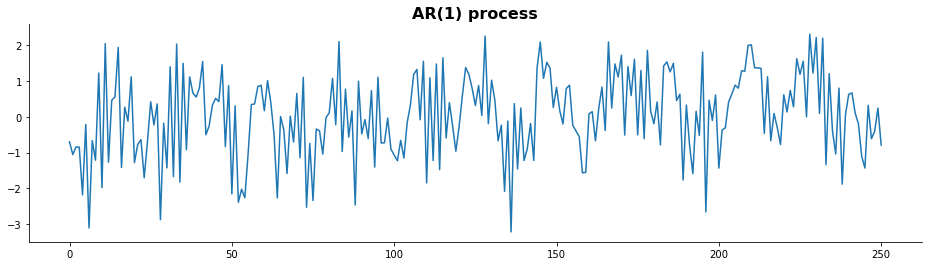

In [3]:
ax = pd.Series(z).plot()
ax.set_title("AR(1) process");

#### Moving Average Process

Now, let's consider the special case of Equation [(1)](#mjx-eqn-ma-infty), wherein we consider only the first $q$ of the $\psi$ weights as none-zero. This may be written as:

$$
\tilde{z}_{t} = a_t - \theta_1 a_{t-1} - \theta a_t{t-2} - ... - \theta_q a_{t-q} \tag{22}
$$

This is the process known as the *moving average process* of the order $q$, which we abbreviate as $MA(q)$.

In particular let's look at the case of $MA(1)$:

$$
\tilde{z}_{t} = a_t - \theta_1 a_{t-1} \tag{23}
$$

##### Example 2: Generating an MA(1) process

Let's take the case when $\theta = 0.25$ and we generate `250` samples

In [4]:
# Set the size variable and random seed
size = 250
np.random.seed(1337)
theta = [1, 0.25]

# White noise term
a = stats.norm.rvs(size=size)

# First term is the first white noise term
z = [a[0]]

# Generate all other points based on 
for t in range(size):
    z.append(a[t] - theta[1]*a[t-1])

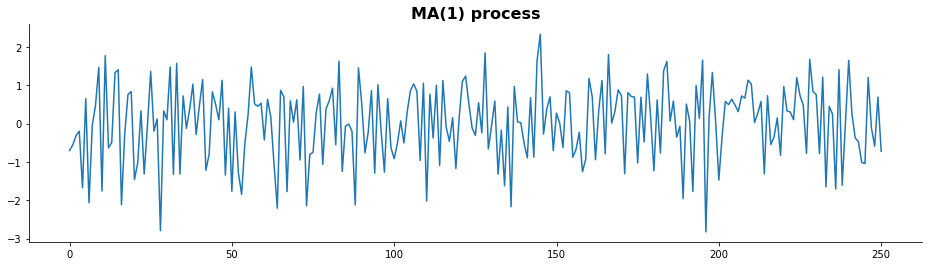

In [5]:
ax = pd.Series(z).plot()
ax.set_title("MA(1) process");

#### Mixed Autoregressive-Moving Average Processes

If we include both autoregressive and moving average terms in the model, we get a compact representation for the linear process. The resulting proces is called the *mixed autoregressive-moving average process* of order $(p, q)$, which we abbreviate as $ARMA(p, q)$. This process can be writen as:

$$
\tilde{z}_{t} =\phi_1 \tilde{z}_{t-1} + ... + \phi_p \tilde{z}_{t-p} + a_t - \theta_1 a_{t-1} - ... - \theta_q a_{t-q} \tag{24}
$$

In particular, let's take a look at the $ARMA(1, 1)$ process:

$$
\tilde{z}_{t} = \phi_1 \tilde{z}_{t-1} + a_t - \theta_1 a_{t-1} \tag{25}
$$

##### Example 3: Generating an ARMA(1, 1) process

Let's take the case when $\phi_1 = 0.50$, $\theta_1 = 0.25$, and we want to generate `250` samples.

In [6]:
# Set the size variable and random seed
size = 250
np.random.seed(1337)
theta = [1, 0.25]
phi = [1, 0.50]

# White noise term
a = stats.norm.rvs(size=size)

# First term is the first white noise term
z = [a[0]]

# Generate all other points based on 
for t in range(size):
    z.append(phi[1]*z[t-1] + a[t] - theta[1]*a[t-1])

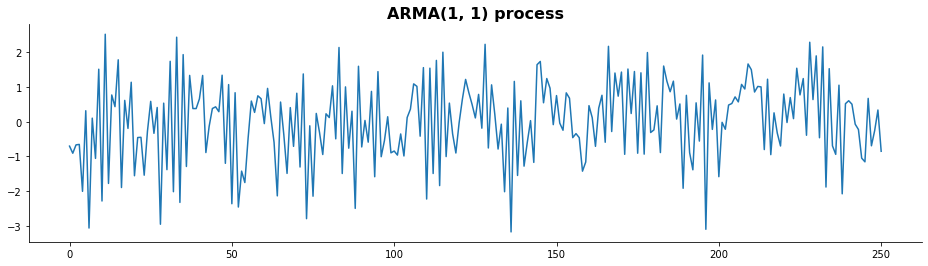

In [7]:
ax = pd.Series(z).plot()
ax.set_title("ARMA(1, 1) process");

<div class="alert alert-info">
    
**Exercise**
    
Generate `250` samples for an ARMA(2, 2) process with coefficients $\phi_1 = 0.25$, $\phi_2 = -0.50$, $\theta_1=0.75$, and $\theta_2 = 0.25$.

</div>

In [8]:
from statsmodels.tsa import arima_process

# Set the size variable and random seed
size = 250
np.random.seed(1337)

# Set parameters, phi values should be negative of what we expect
phi = np.array([1, -0.25, 0.50])
theta = np.array([1, 0.75, 0.25])

z = arima_process.arma_generate_sample(phi, theta, 250)

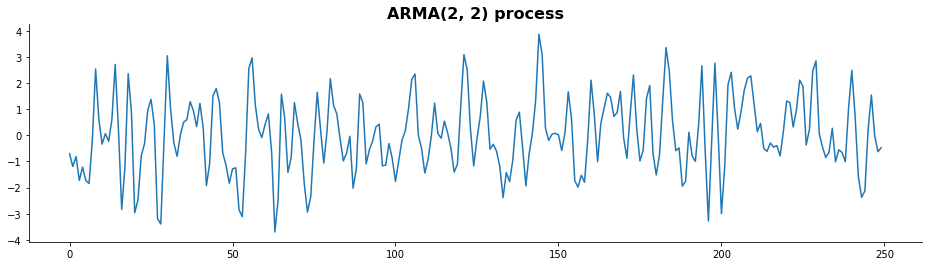

In [9]:
ax = pd.Series(z).plot()
ax.set_title("ARMA(2, 2) process");

## Linear Non-Stationary Models

Previously we considered the **ARMA** model with $\phi$ and $\theta$ having the order $p$ and $q$. To ensure stationarity the roots of $\phi(B) = 0$ must lie outside the unit circle. One way of obtaining a nonstationary process is to relax this restrction.

For example take the first-order autoregressive model, 

$$
(1 - \phi B) \tilde{z}_{t} = a_t \tag{26}
$$

which is stationary for $|\phi| < 1$. Let's see what happens when we set $\phi = 2$, a value outside the stationary range

In [10]:
# Set the size variable and random seed
size = 250
np.random.seed(1337)

# Set phi and theta values
phi = np.array([1, -2])
theta = np.array([1])

z = arima_process.arma_generate_sample(phi, theta, 250)

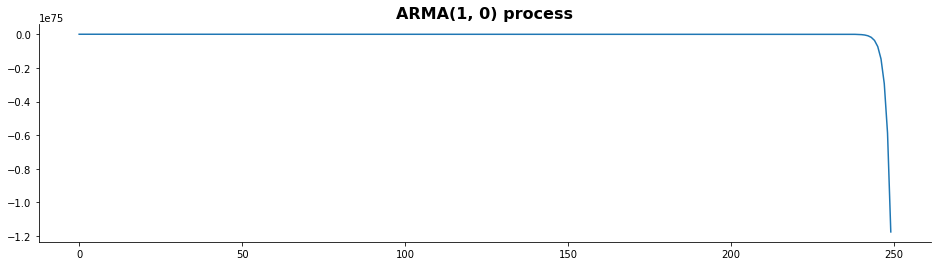

In [11]:
ax = pd.Series(z).plot()
ax.set_title("ARMA(1, 0) process");

These kinds of explosive or evolutionary behavior is similar to how bacteria grows.

### Autoregressive Integrated Moving Average Model

Another way that we can produce nonstationary behavior is wehn the roots of $\phi(B) = 0$ lie on the unit circle.

Consider the model

$$
\varphi(B)\tilde{z}_{t} = \theta(B)a_t \tag{27}
$$

where $\varphi(B)$ is a nonstationary autoregressive operator such that $d$ of the roots of $\varphi(B) = 0$ are equal to $1$ and the remainder lie outside the unit circle.

This means, we can write the model as,

$$
\varphi(B)\tilde{z}_{t} = \phi(B)(1 - B)^d \tilde{z}_{t} = \theta(B)a_t \tag{28}
$$

Let $\nabla$ be the differencing operator $1-B$, we can write the model as:

$$
\phi(B) \nabla^d \tilde{z}_{t} = \theta(B) a_t \tag{29}
$$

Equivalently this process can be defined in terms of two steps:

(1) The ARMA process

$$
\phi(B)w_t = \theta(B) a_t \tag{30}
$$

and

(2) The differencing process

$$
w_t = \nabla^d z_t \tag{31}
$$

##### Example 4

Generate an $ARIMA(2, 1, 2)$ process with coefficients  $\phi_1 = 0.25$, $\phi_2 = -0.50$, $\theta_1=0.75$, and $\theta_2 = 0.25$. Plot its ACF and PACF.

In [12]:
from statsmodels.tsa import arima_process

# Set the size variable and random seed
size = 250
np.random.seed(1337)

# Set parameters, phi values should be negative of what we expect
phi = np.array([1, -0.25, 0.50])
theta = np.array([1, 0.75, 0.25])

# Generate the time-series for w
w = arima_process.arma_generate_sample(phi, theta, 250) # ARMA(2, 2) or ARIMA(2, 0, 2)

# From w, generate z
z = w.cumsum()

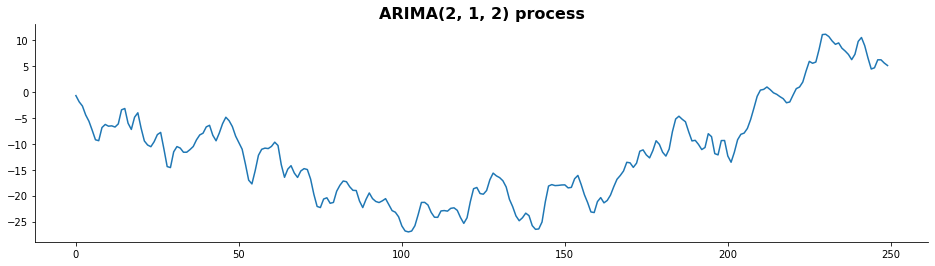

In [13]:
ax = pd.Series(z).plot()
ax.set_title("ARIMA(2, 1, 2) process");

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Plot the PACF and ACF of the original time-series

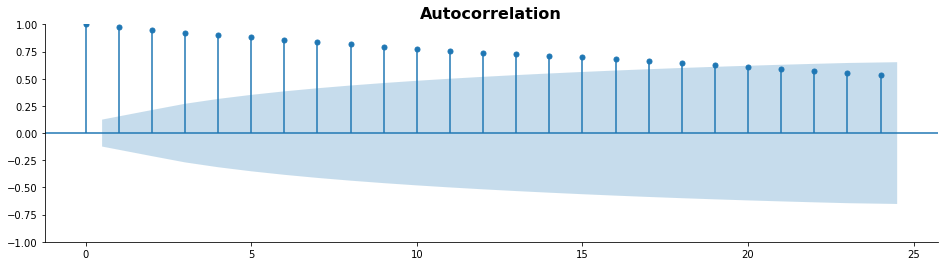

In [15]:
plot_acf(z);

C:\Users\Computer2\anaconda3\envs\phd2024_atsa\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


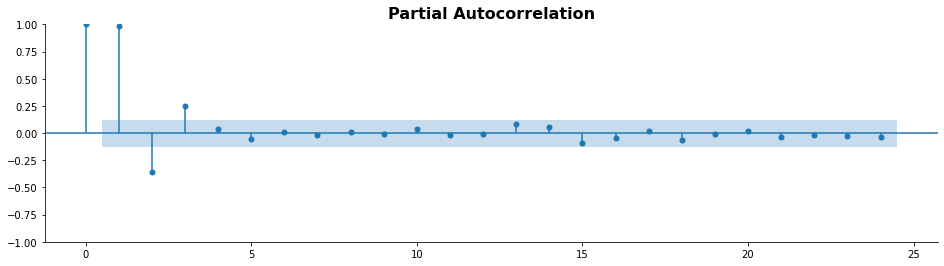

In [16]:
plot_pacf(z);

Plot the ACF and PACF of the differenced series

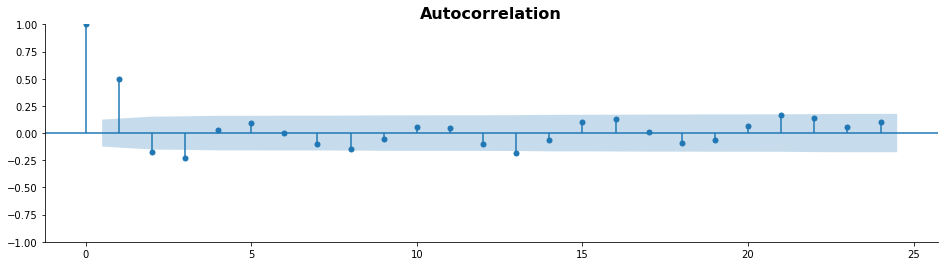

In [17]:
plot_acf(w);

C:\Users\Computer2\anaconda3\envs\phd2024_atsa\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


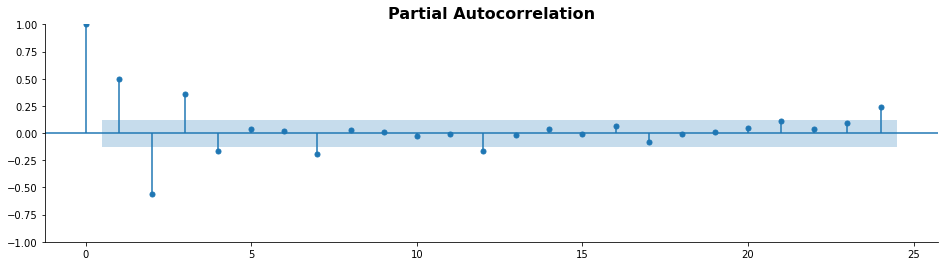

In [18]:
plot_pacf(w);

## Model Identification

Now that we have the foundation of how ARMA and ARIMA process works. Let's look at how we can use these processes to model time series. Here is a recommended pipeline when we are identifying which model parameters to use in fitting linear models.

**Step 1**: Examine the time-series plot

First step is to plot the time-series $z_t$ against $t$ and examine obvious trends, seasonal components, and outliers. These should be removed using differencing, moving-average, or other appropriate methods.

**Step 2**: Examine the correlogram

Trend and seasonal components may show up in the ACF. A slow damping correlogram indicates a slow trend component. A periodic fluctuating is indicative of a periodic component.

**Step 3**: Determine the MA-order $q$ from the ACF, while the AR order $p$ from the PACF.

**Step 4**: Determine the orders using Akaike Information Criterion (AIC) or other information criteria such as Bayesian Information Criterios (BIC).

**Step 5**: Perform a diagnostic test that the residuals do indeed look like white noise.

## Forecasting the M5 Food Category Dataset

In [19]:
# Load the data
data = (pd.read_csv('../../data/m5-food-revenue.csv',
                    parse_dates=['date'])
          .set_index('date').revenue)

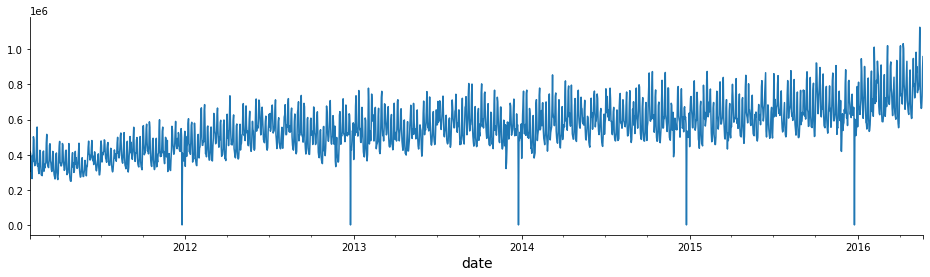

In [20]:
data.plot();

In [21]:
# Handle outliers
data[data.sort_values().head(5).index] = np.nan
data = data.fillna(method='ffill')

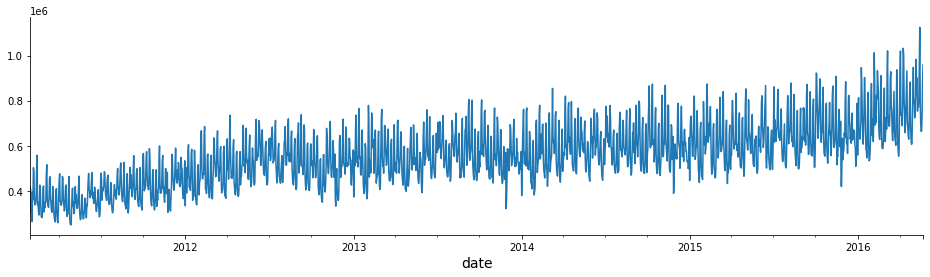

In [22]:
data.plot();

In [23]:
# Get training data
train_data = data.iloc[:-28]
test_data = data.iloc[-28:]

In [24]:
diff_train_data = (train_data - train_data.shift()).dropna()

<AxesSubplot:xlabel='date'>

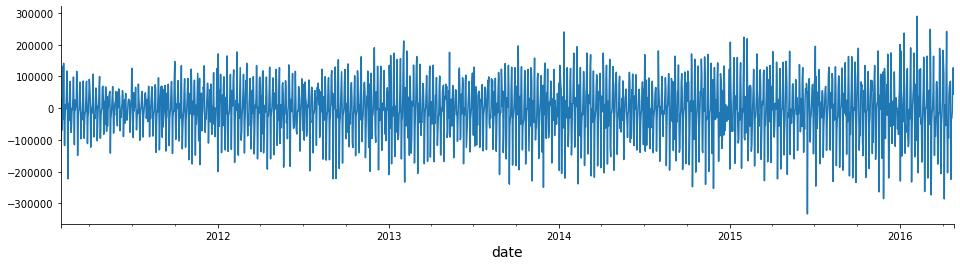

In [25]:
diff_train_data.plot()

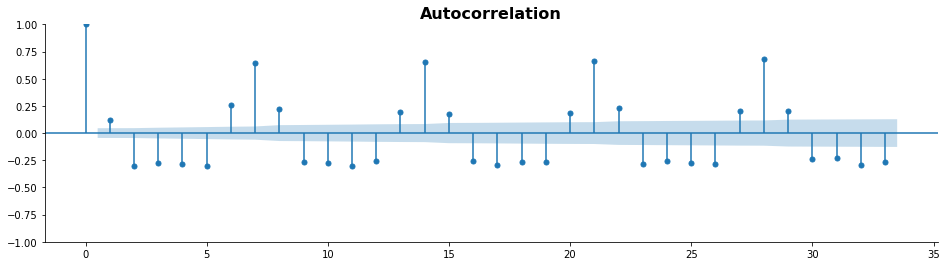

In [26]:
plot_acf(diff_train_data);

In [27]:
weekly_diff_train_data = (diff_train_data - diff_train_data.shift(7)).dropna()

<AxesSubplot:xlabel='date'>

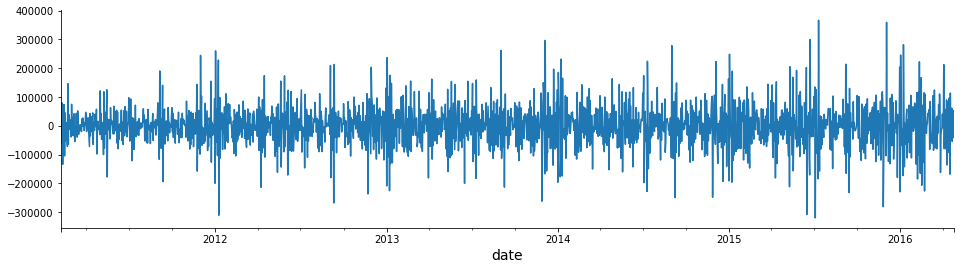

In [28]:
weekly_diff_train_data.plot()

In [29]:
from statsmodels.tsa.stattools import kpss, adfuller

# Convenience functions for ADF and KPSS tests, taken from https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html
def adf_test(timeseries, *args, **kwargs):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, *args,  **kwargs)
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used',
                                'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [30]:
adf_test(weekly_diff_train_data)

Results of Dickey-Fuller Test:
Test Statistic                  -22.597563
p-value                           0.000000
#Lags Used                       26.000000
Number of Observations Used    1878.000000
Critical Value (1%)              -3.433837
Critical Value (5%)              -2.863080
Critical Value (10%)             -2.567590
dtype: float64


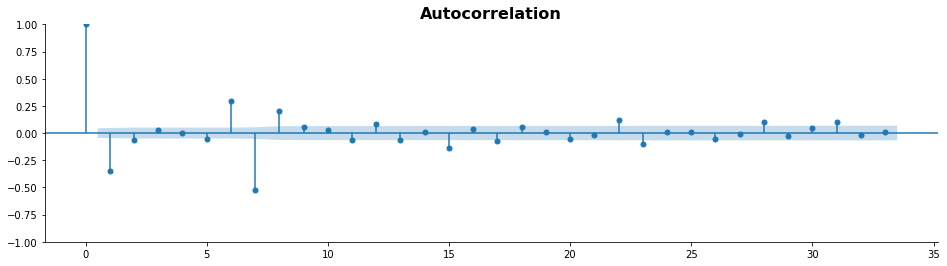

In [31]:
plot_acf(weekly_diff_train_data);

C:\Users\Computer2\anaconda3\envs\phd2024_atsa\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


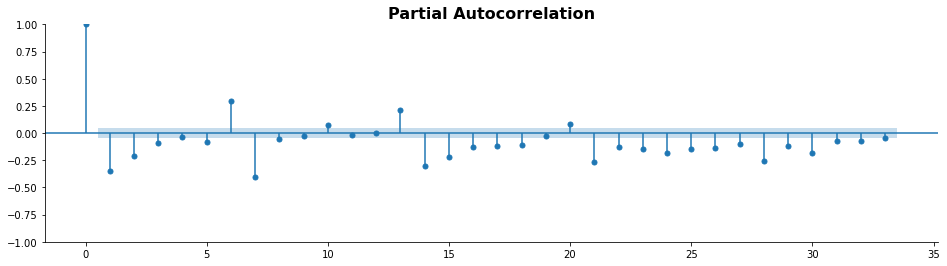

In [32]:
plot_pacf(weekly_diff_train_data);

Choose p from 0 to 7, and q from 0 to 7

In [33]:
import warnings
import itertools
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore")

p_grid = range(8)
d_grid = [0]
q_grid = range(8)

models = {}
for pdq in itertools.product(p_grid, d_grid, q_grid):
    print(f"Currently evaluating: {pdq}")
    model = ARIMA(weekly_diff_train_data, order=pdq).fit()
    models[pdq] = model

Currently evaluating: (0, 0, 0)
Currently evaluating: (0, 0, 1)
Currently evaluating: (0, 0, 2)
Currently evaluating: (0, 0, 3)
Currently evaluating: (0, 0, 4)
Currently evaluating: (0, 0, 5)
Currently evaluating: (0, 0, 6)
Currently evaluating: (0, 0, 7)
Currently evaluating: (1, 0, 0)
Currently evaluating: (1, 0, 1)
Currently evaluating: (1, 0, 2)
Currently evaluating: (1, 0, 3)
Currently evaluating: (1, 0, 4)
Currently evaluating: (1, 0, 5)
Currently evaluating: (1, 0, 6)
Currently evaluating: (1, 0, 7)
Currently evaluating: (2, 0, 0)
Currently evaluating: (2, 0, 1)
Currently evaluating: (2, 0, 2)
Currently evaluating: (2, 0, 3)
Currently evaluating: (2, 0, 4)
Currently evaluating: (2, 0, 5)
Currently evaluating: (2, 0, 6)
Currently evaluating: (2, 0, 7)
Currently evaluating: (3, 0, 0)
Currently evaluating: (3, 0, 1)
Currently evaluating: (3, 0, 2)
Currently evaluating: (3, 0, 3)
Currently evaluating: (3, 0, 4)
Currently evaluating: (3, 0, 5)
Currently evaluating: (3, 0, 6)
Currentl

In [34]:
aic_res = {}
bic_res = {}
for pdq in models:
    aic_res[pdq] = models[pdq].aic
    bic_res[pdq] = models[pdq].bic

In [35]:
results = pd.DataFrame([aic_res, bic_res], index=['aic', 'bic']).T

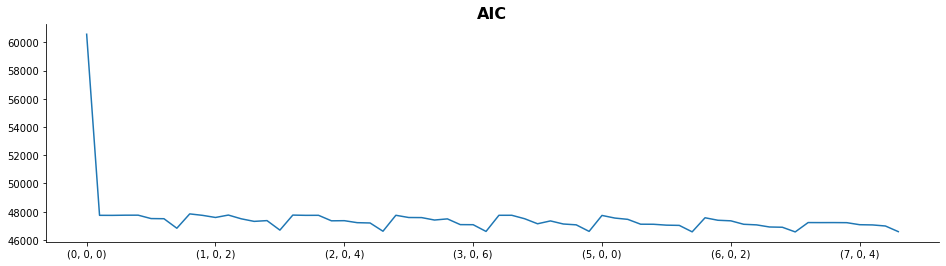

In [36]:
ax = results.aic.plot()
ax.set_title("AIC");

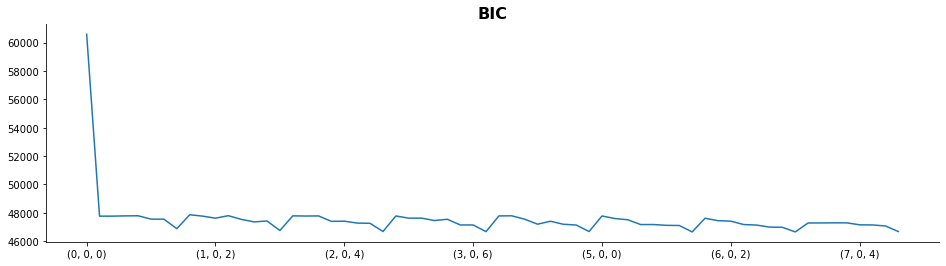

In [37]:
ax = results.bic.plot()
ax.set_title("BIC");

In [38]:
results.aic.sort_values().head(5)

(6, 0, 7)    46565.745947
(5, 0, 7)    46570.443549
(7, 0, 7)    46585.237356
(3, 0, 7)    46600.785816
(4, 0, 7)    46603.731493
Name: aic, dtype: float64

In [39]:
results.bic.sort_values().head(5)

(5, 0, 7)    46648.174871
(6, 0, 7)    46649.029507
(3, 0, 7)    46667.412663
(7, 0, 7)    46674.073153
(2, 0, 7)    46675.251939
Name: bic, dtype: float64

In [40]:
from statsmodels.stats.diagnostic import acorr_ljungbox

p-values should be > 0.050 to say that the residuals have no correlation

In [41]:
acorr_ljungbox(models[(5, 0, 7)].resid)

,lb_stat,lb_pvalue
1,0.305962,0.580169
2,1.989692,0.369780
3,2.330604,0.506683
4,2.500816,0.644490
5,3.964165,0.554587
6,5.836055,0.441804
7,5.842130,0.558299
8,8.331349,0.401790
9,11.445046,0.246432
10,17.309220,0.067796


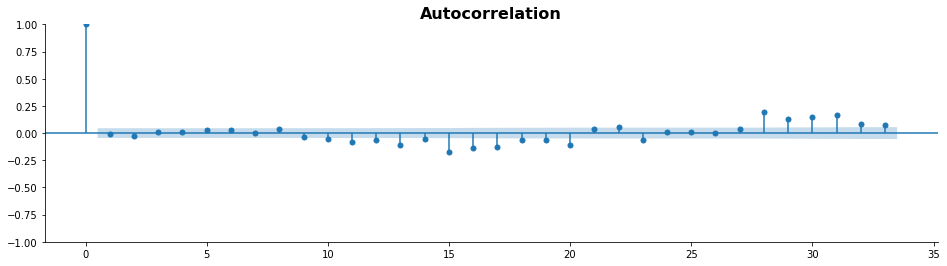

In [42]:
plot_acf(models[(5, 0, 7)].resid);

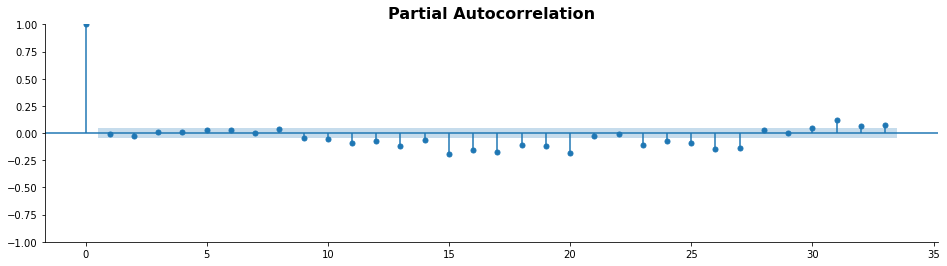

In [43]:
plot_pacf(models[(5, 0, 7)].resid);

In [44]:
acorr_ljungbox(models[(6, 0, 7)].resid)

,lb_stat,lb_pvalue
1,0.212062,0.645156
2,0.231131,0.890862
3,0.751124,0.861118
4,1.080747,0.897315
5,1.263308,0.938662
6,2.589934,0.858270
7,2.766211,0.905755
8,6.287625,0.615048
9,8.767837,0.458975
10,14.219344,0.163220


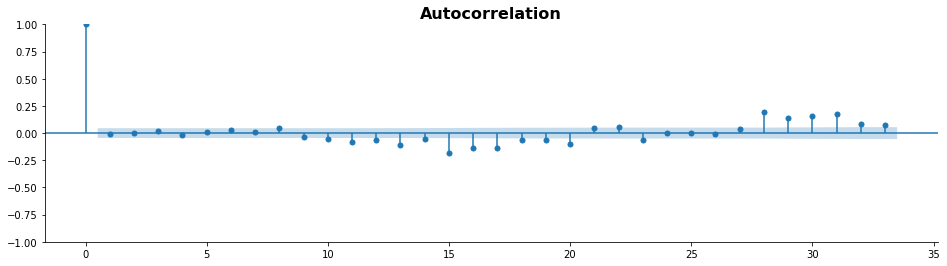

In [45]:
plot_acf(models[(6, 0, 7)].resid);

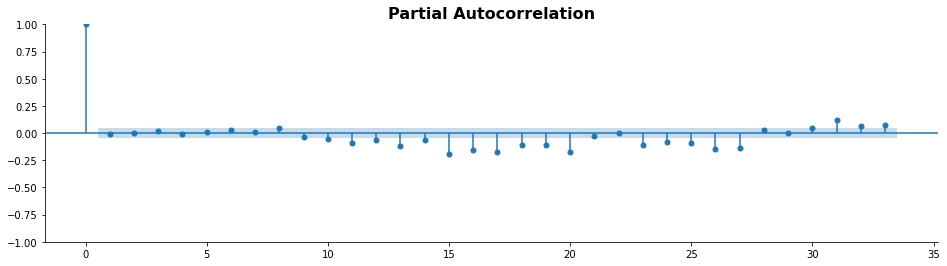

In [46]:
plot_pacf(models[(6, 0, 7)].resid);

### Make Forecast

In [47]:
model_pdq = (5, 0, 7)
horizon = 28
m = 7

forecast = models[model_pdq].forecast(horizon)

offset = weekly_diff_train_data[-7:].tolist()
offset.extend(np.zeros(28 - 7))

forecast = forecast + forecast.shift(7).fillna(0) + np.array(offset)
forecast = forecast + forecast.shift().fillna(0) + train_data[0]

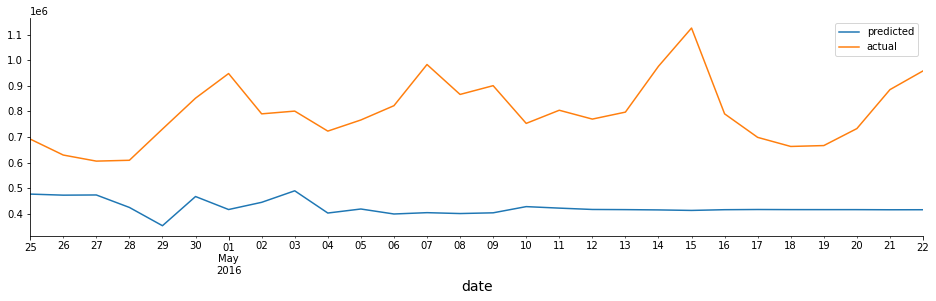

In [48]:
ax = (forecast).plot(label='predicted')
test_data.plot(ax=ax, label='actual')
ax.legend();

In [49]:
model_pdq = (6, 0, 7)
horizon = 28
m = 7

forecast = models[model_pdq].forecast(horizon)

offset = weekly_diff_train_data[-7:].tolist()
offset.extend(np.zeros(28 - 7))

forecast = forecast + forecast.shift(7).fillna(0) + np.array(offset)
forecast = forecast + forecast.shift().fillna(0) + train_data[0]

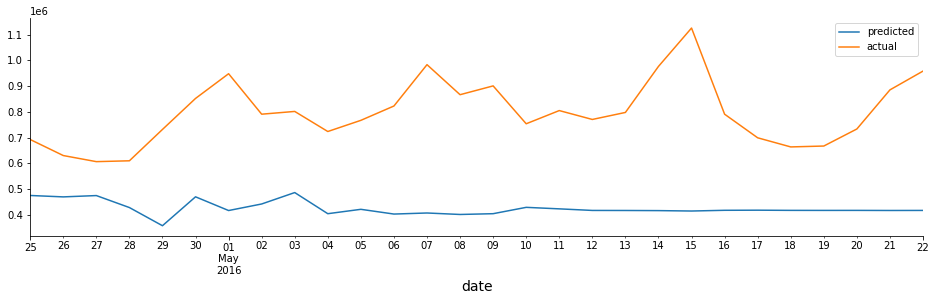

In [50]:
ax = (forecast).plot(label='predicted')
test_data.plot(ax=ax, label='actual')
ax.legend();

Further improve the forecast:
1. Look at the mean result on the test dataset.
2. Distribution of forecasted and actual value.
3. **Step 6:** Add DC bias.

In [51]:
2*3.14/3

2.0933333333333333